In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os


In [13]:

def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / denominator

def combined_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


In [14]:

def unet_model(input_shape=(512, 512, 1)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.2)(conv5)

    # Decoder
    up6 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=combined_loss, metrics=['accuracy'])

    return model




Epoch 1/50
14/14 [==============================] - 17s 331ms/step - loss: 1.0244 - accuracy: 0.6271 - val_loss: 1.0291 - val_accuracy: 0.7663
Epoch 2/50
14/14 [==============================] - 4s 287ms/step - loss: 0.7641 - accuracy: 0.7729 - val_loss: 0.9617 - val_accuracy: 0.7663
Epoch 3/50
14/14 [==============================] - 4s 296ms/step - loss: 0.6459 - accuracy: 0.8467 - val_loss: 0.8890 - val_accuracy: 0.7663
Epoch 4/50
14/14 [==============================] - 4s 291ms/step - loss: 0.5661 - accuracy: 0.8809 - val_loss: 0.8327 - val_accuracy: 0.7663
Epoch 5/50
14/14 [==============================] - 4s 293ms/step - loss: 0.5084 - accuracy: 0.8988 - val_loss: 0.7818 - val_accuracy: 0.7663
Epoch 6/50
14/14 [==============================] - 4s 301ms/step - loss: 0.4709 - accuracy: 0.9098 - val_loss: 0.7571 - val_accuracy: 0.7663
Epoch 7/50
14/14 [==============================] - 4s 300ms/step - loss: 0.4345 - accuracy: 0.9168 - val_loss: 0.7530 - val_accuracy: 0.7663
Epoch

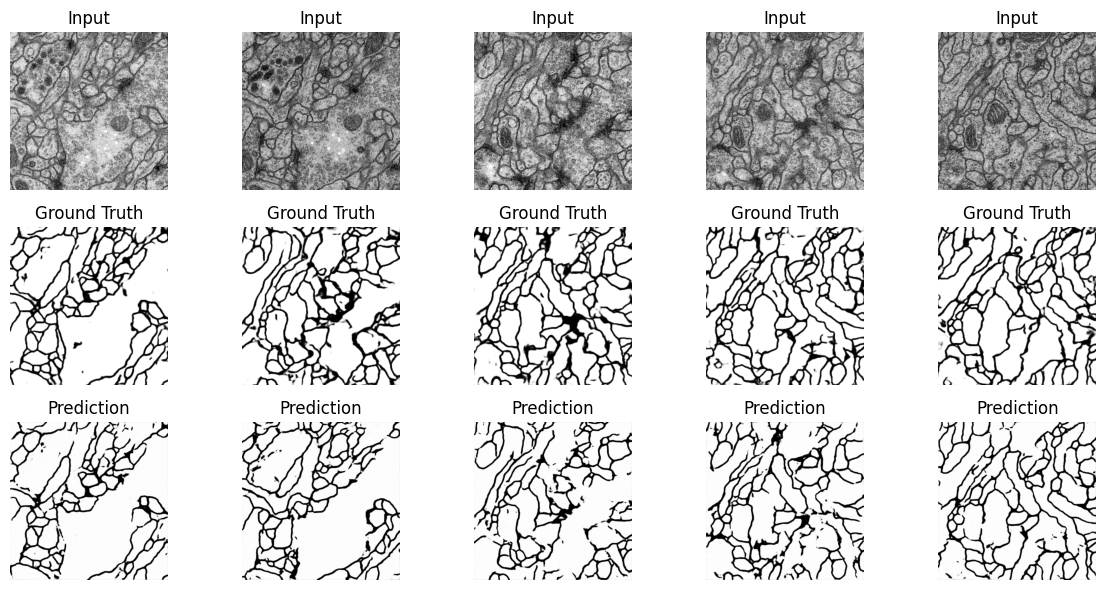

In [11]:
# Load and preprocess data
def load_data(image_path, label_path, image_size=(512, 512)):
    images = []
    labels = []

    image_files = sorted(os.listdir(image_path))
    label_files = sorted(os.listdir(label_path))

    for img_file, label_file in zip(image_files, label_files):
        img = tf.keras.preprocessing.image.load_img(os.path.join(image_path, img_file), target_size=image_size, color_mode='grayscale')
        label = tf.keras.preprocessing.image.load_img(os.path.join(label_path, label_file), target_size=image_size, color_mode='grayscale')

        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        label = tf.keras.preprocessing.image.img_to_array(label) / 255.0

        images.append(img)
        labels.append(label)

    return np.array(images), np.array(labels)

# Example paths, replace with your actual paths
train_images, train_labels = load_data('/content/drive/MyDrive/Colab Notebooks/membrane/train/image', '/content/drive/MyDrive/Colab Notebooks/membrane/train/label')
test_images, test_labels = load_data('/content/drive/MyDrive/Colab Notebooks/membrane/test/image', '/content/drive/MyDrive/Colab Notebooks/membrane/test/label')

train_labels = np.expand_dims(train_labels, axis=-1)
test_labels = np.expand_dims(test_labels, axis=-1)

# Train the model
model = unet_model()

history = model.fit(train_images, train_labels,
                    validation_split=0.1,
                    epochs=50,
                    batch_size=2)

# Save the model
model.save('unet_membrane.h5')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_images, test_labels, batch_size=2)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Visualize some predictions
predictions = model.predict(test_images)

n = 5  # number of samples to visualize
plt.figure(figsize=(12, 6))
for i in range(n):
    plt.subplot(3, n, i + 1)
    plt.imshow(test_images[i].reshape(512, 512), cmap='gray')
    plt.title('Input')
    plt.axis('off')

    plt.subplot(3, n, i + n + 1)
    plt.imshow(test_labels[i].reshape(512, 512), cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(3, n, i + 2 * n + 1)
    plt.imshow(predictions[i].reshape(512, 512), cmap='gray')
    plt.title('Prediction')
    plt.axis('off')

plt.tight_layout()
plt.show()